# Closed-form equivalent layer associated with gravitational field

This code illustrates how to compute a planar closed-form equivalent layer that reproduces the gravitational potential and its derivatives at points above the layer.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag import eqlayer, filters, transforms, convolve
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf
from gravmag import constants as cts

### Model

In [2]:
# Create a model formed by a single prism
model = np.array([[-500, 500, 0, 2000, 10, 1010]])

density = np.array([2000]) # 2000 kg/m³ = 2 g/cm³

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (60, 60)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)

yp = np.ravel(yp)
xp = np.ravel(xp)

# constant vertical coordinate of the simulated gravity data
z_data = -150

zp = np.zeros_like(yp) + z_data

coordinates = np.vstack([xp, yp, zp])

In [4]:
# Grid spacing
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

In [5]:
print(dx, dy)

169.4915254237288 169.4915254237288


### Synthetic gravitational field

In [6]:
# gravitational potential (in m²/s²)
U = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_potential')

# acceleration components (in mGal)
gx = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_x')
gy = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_y')
gz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_z')

# tensor components (in Eötvös)
gxx = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_xx')
gxy = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_xy')
gxz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_xz')
gyy = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_yy')
gyz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_yz')
gzz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_zz')

### Theoretical equivalent layer

Compute the theoretical physical-property distribution on the layer via Fourier transform.

In [7]:
# layer z
z_layer = -150 + 2.5*(0.5*(dx+dy))

In [8]:
# compute 2D Fourier transform of gz with padding
FT_gz = transforms.DFT(data=gz.reshape(shape), pad_mode='linear_ramp')

# compute wavenumbers
kx, ky, kz = transforms.wavenumbers(FT_gz.shape, dx, dy)

In [9]:
# define the continuation filter
down_continuation_filter = [filters.continuation(kz=kz, dz=z_layer-z_data)]

In [10]:
# compute the downward continued field in Fourier domain
FT_gz_downward_layer = convolve.compute(FT_gz, down_continuation_filter)

In [11]:
# transform the downward continued field to space domain
gz_downward_layer = transforms.IDFT(FT_gz_downward_layer, unpad=True, grid=False)

In [12]:
# theoretical equivalent layer
p_theoretical = ((dx*dy)/(2*np.pi*cts.SI2MGAL))*gz_downward_layer

### Gravitational field predicted by the theoretical equivalent layer

In [13]:
# gravitational field components
field_scales = [
    1, cts.SI2MGAL, cts.SI2MGAL, cts.SI2MGAL, 
    cts.SI2EOTVOS, cts.SI2EOTVOS, cts.SI2EOTVOS, cts.SI2EOTVOS, cts.SI2EOTVOS, cts.SI2EOTVOS
]
field_names = ['potential', 'x', 'y', 'z', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']
field_units = ['m²/s²', 'mGal', 'mGal', 'mGal', 'E', 'E', 'E', 'E', 'E', 'E']

In [14]:
# list for storing the predicted gravitational field components
predicted_fields = []

In [15]:
for name, scale in zip(field_names, field_scales):
    # kernel matrix associated with the equivalent layer
    G = eqlayer.kernel_matrix_monopoles(coordinates, z_layer, field=name)
    # compute the predicted field and update the list
    predicted_fields.append(scale*G@p_theoretical)

### Plot the results

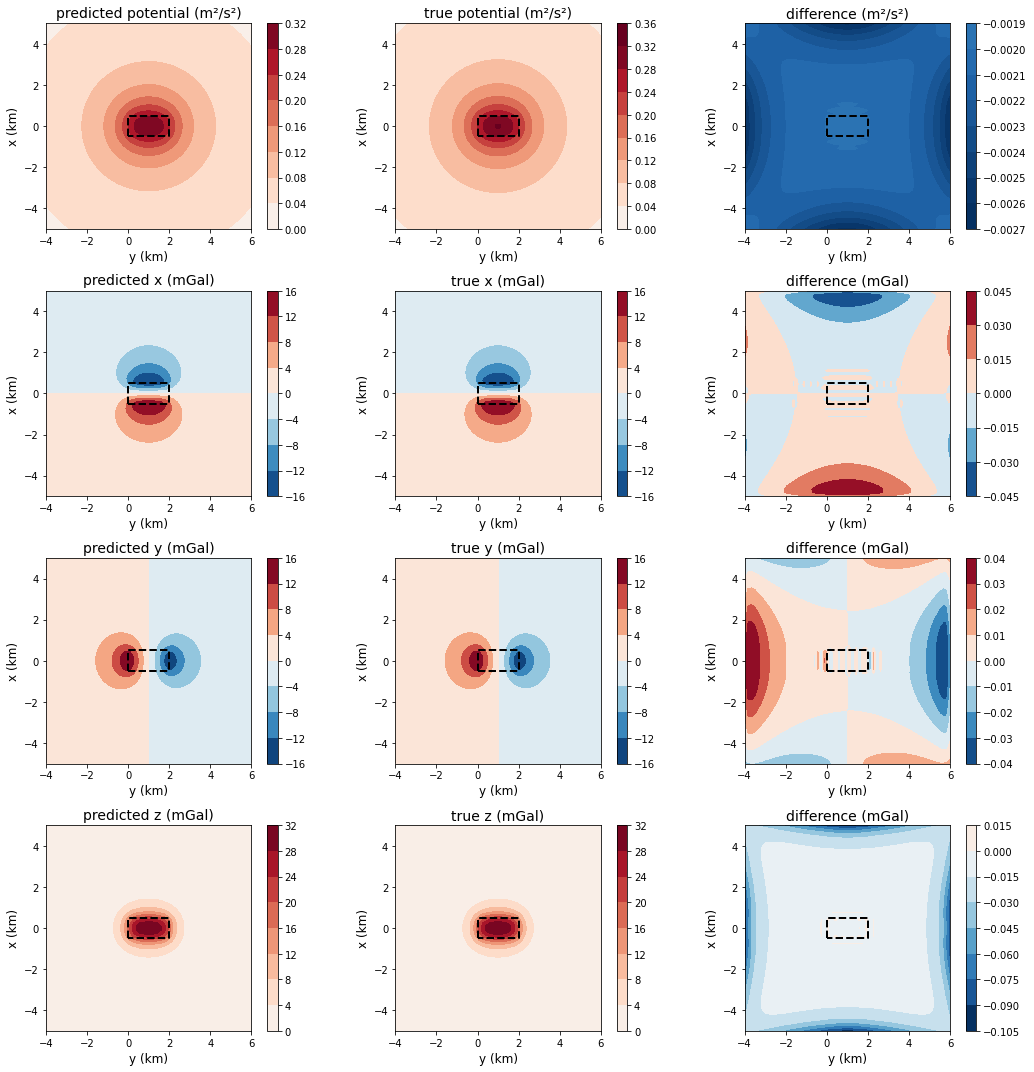

In [18]:
true_fields = [U, gx, gy, gz]

bounds, diffs = plf.bounds_diffs(predicted_fields[:4], true_fields)

fields = plf.fields_list(predicted_fields[:4], true_fields, diffs)

titles = []
for name, unit in zip(field_names[:4], field_units[:4]):
    titles.append('predicted {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,13)]

plt.figure(figsize=(15,15))

for w, window in enumerate(windows):

    plt.subplot(4,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

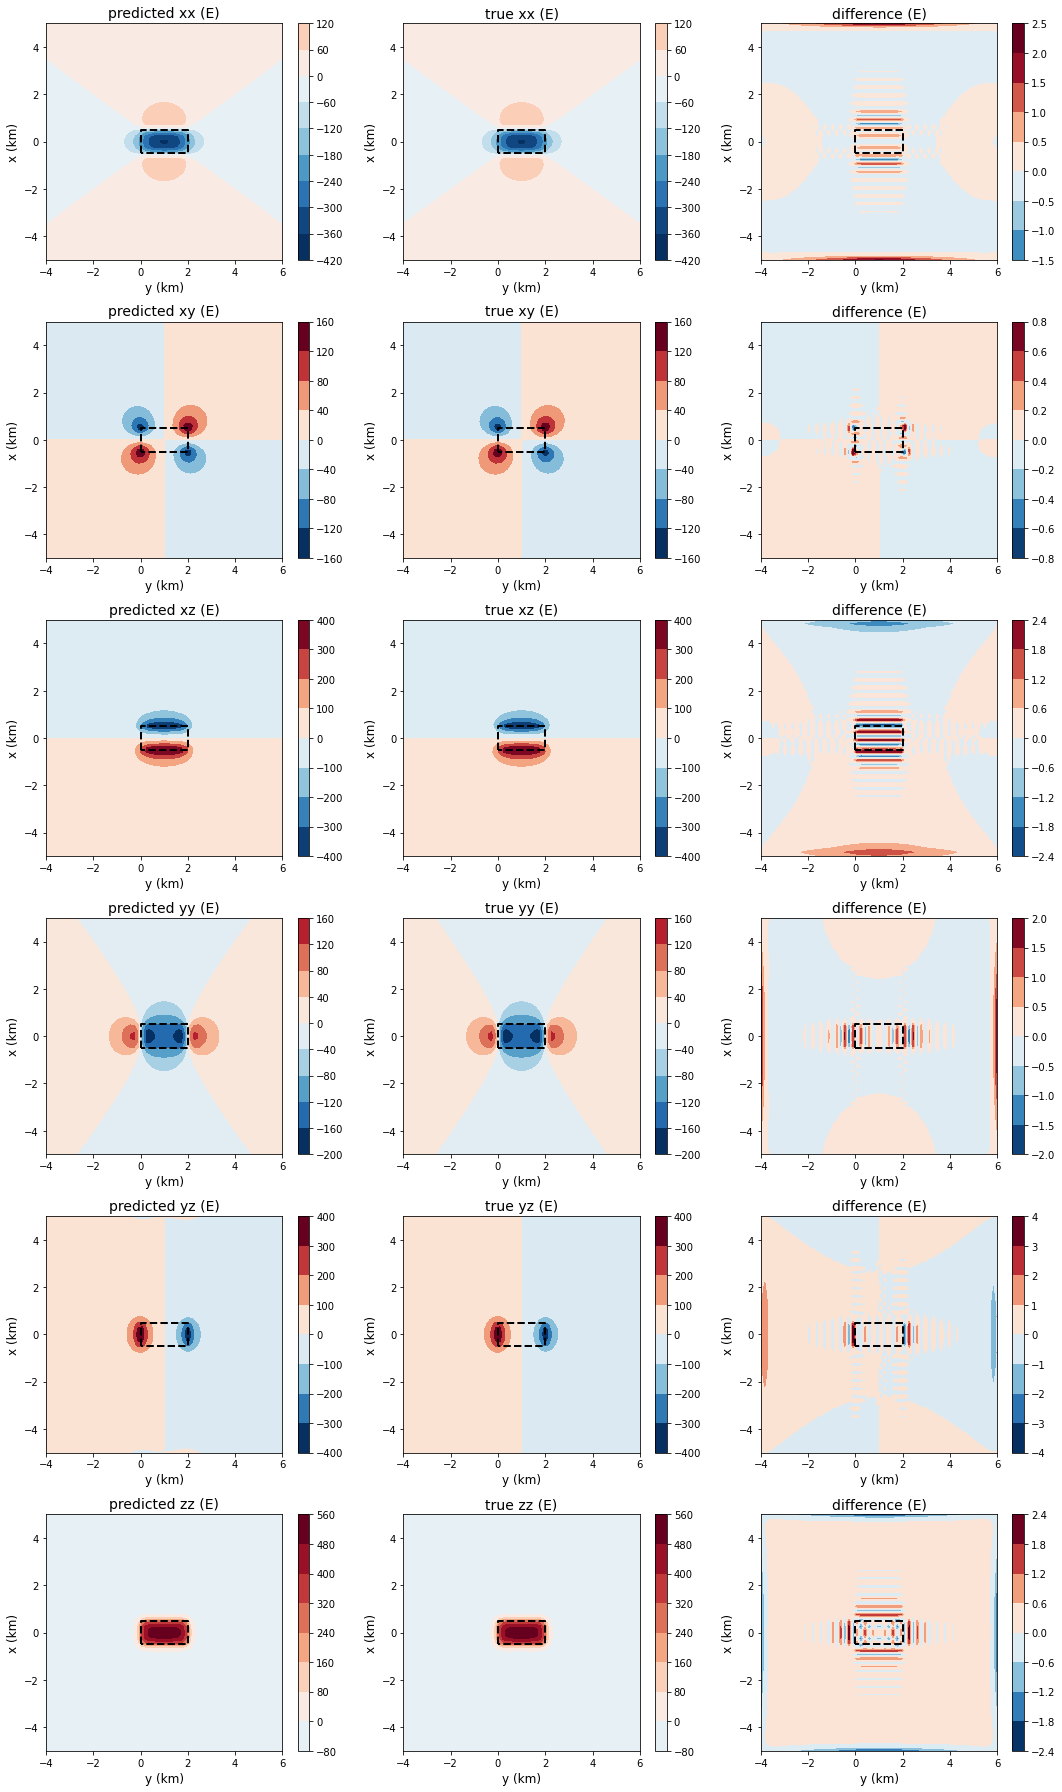

In [20]:
true_fields = [gxx, gxy, gxz, gyy, gyz, gzz]

bounds, diffs = plf.bounds_diffs(predicted_fields[4:], true_fields)

fields = plf.fields_list(predicted_fields[4:], true_fields, diffs)

titles = []
for name, unit in zip(field_names[4:], field_units[4:]):
    titles.append('predicted {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1, 19)]

plt.figure(figsize=(15,25))

for w, window in enumerate(windows):

    plt.subplot(6,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()